In [1]:
from collections import OrderedDict
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

# 1 - Main figure (comparison between attack models using 3 columns)

In [2]:
experiments_dir = '../../experiments'
logreg_grid_attack_results_path = \
    f'{experiments_dir}/grid_attack/cols-3/l-[100, 100]_ns-1500_nds-1500_tts-0.0_sts-0.3333_ndsbb-100_smt-logreg_mmt-logreg_nb-3_sgf--1.pickle'
with open(logreg_grid_attack_results_path, 'rb') as f:
    logreg_grid_attack_results = pickle.load(f)
    
mlp_grid_attack_results_path = \
    f'{experiments_dir}/grid_attack/cols-3/old_l-[100, 100]_ns-1500_nds-1000_ndsbb-100_smt-mlptorch_mmt-mlptorch_nb-3_sgf--1.pickle'
with open(mlp_grid_attack_results_path, 'rb') as f:
    mlp_grid_attack_results = pickle.load(f)
    
bounds_list = logreg_grid_attack_results['bounds_list']

In [3]:
logreg_grid_attack_results['accs_shadow_test'][(0.5, 0.5)]

0.7399720000000001

In [4]:
accuracy_attack_3col =  [
    # Results for no access to ML (uniform prior empirical).
    [[logreg_grid_attack_results['results'][(a, b)]['uniform_prior_empirical_results']['acc']
    for b in bounds_list[1]] 
    for a in bounds_list[0][::-1]],
    # Results for a logistic regression using black-box access.
    [[logreg_grid_attack_results['results'][(a, b)]['model_predictions'][0] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]],
    # Results for an MLP using black-box access.
    [[mlp_grid_attack_results['results'][(a, b)]['model_predictions'][0] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]]
]

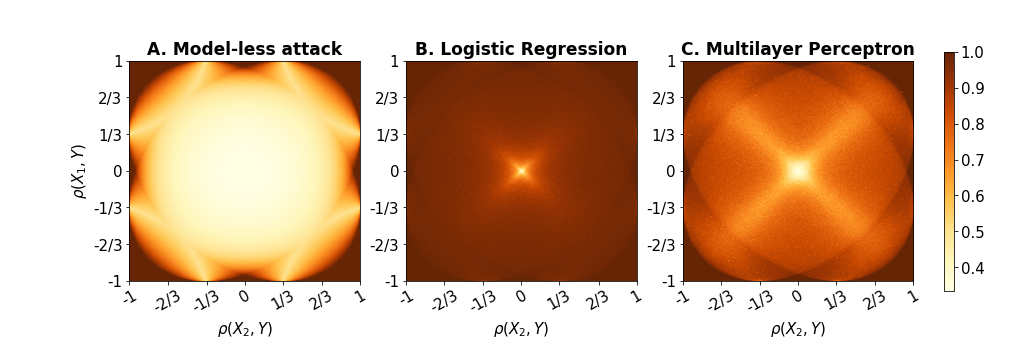

In [5]:
titles = ['A. Model-less attack', 'B. Logistic Regression', 'C. Multilayer Perceptron']

nbr_plots = len(accuracy_attack_3col)
fig, axes = plt.subplots(1, nbr_plots, figsize=(15.5, 5.5))

cmap = sns.color_palette("YlOrBr", as_cmap=True)
    
ticks = np.round(np.arange(-1, 1.01, 1/3), 2)
ticklabels = ['-1', '-2/3', '-1/3', '0', '1/3', '2/3', '1']
    
for i, ax in enumerate(axes):
    im = ax.imshow(accuracy_attack_3col[i], extent=[-1.0, 1.0, -1.0, 1.0], cmap=cmap, vmin=1/3, vmax=1.0)
    
    if i == nbr_plots-1:
        cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
        cbar_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        fig.colorbar(im, cax=cbar_ax, ticks=cbar_ticks)
        cbar_ax.set_yticklabels(cbar_ticks, fontsize=15)

    # Plot.
    ax.set_xticks(ticks)
    ax.set_xlabel('$\\rho(X_2, Y)$', fontsize=15)
    ax.set_xticklabels(ticklabels, rotation=30, fontsize=15)
    if i == 0:
        ax.set_ylabel('$\\rho(X_1, Y)$', fontsize=15)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels, fontsize=15)
    ax.set_title(titles[i], fontsize=17, fontweight='bold')
        
plt.savefig('../../plots/grid-attack.pdf', bbox_inches='tight')
plt.savefig('../../plots/grid-attack.png', bbox_inches='tight')
plt.show()

## Detailed results for the logistic regression

In [6]:
print(f'Average accuracy for no access to ML model (uniform prior empirical) {np.mean(accuracy_attack_3col[0]):.1%}')
for method in ['model_weights', 'model_predictions', 'combined']:
    test_accuracy_method = [[logreg_grid_attack_results['results'][(a, b)][method][0] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]]
    train_accuracy_method = [[logreg_grid_attack_results['results'][(a, b)][method][2] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]]
    print(f'Average accuracy for access to {method} train: {np.mean(train_accuracy_method):.1%}',
         f'test: {np.mean(test_accuracy_method):.1%}')

Average accuracy for no access to ML model (uniform prior empirical) 56.0%
Average accuracy for access to model_weights train: 95.3% test: 95.1%
Average accuracy for access to model_predictions train: 95.8% test: 95.6%
Average accuracy for access to combined train: 95.8% test: 95.6%


## Center of the cross

In [7]:
model_less_accs, model_based_accs = [], []
for i in range(-2, 2):
    for j in range(-2, 2):
        a, b = i/100, j/100
        model_less_acc = logreg_grid_attack_results['results'][(a, b)]['uniform_prior_empirical_results']['acc']
        model_based_acc = logreg_grid_attack_results['results'][(a, b)]['model_predictions'][0]
        model_less_accs.append(model_less_acc)
        model_based_accs.append(model_based_acc)
print(f'Model-less attack: {np.mean(model_less_accs):.1%}, model-based attack: {np.mean(model_based_accs):.1%}')

Model-less attack: 33.4%, model-based attack: 47.0%


## Arms of the cross

In [8]:
model_less_accs, model_based_accs = [], []
for i in range(0, 5):
    a, b = i/100, i/100
    model_less_acc = logreg_grid_attack_results['results'][(a, b)]['uniform_prior_empirical_results']['acc']
    model_based_acc = logreg_grid_attack_results['results'][(a, b)]['model_predictions'][0]
    model_less_accs.append(model_less_acc)
    model_based_accs.append(model_based_acc)
print(f'Model-less attack: {np.mean(model_less_accs):.1%}, model-based attack: {np.mean(model_based_accs):.1%}')

Model-less attack: 33.4%, model-based attack: 55.0%


## Detailed results for the multilayer perceptron

In [9]:
print(f'Average accuracy for no access to ML model (uniform prior empirical) {np.mean(accuracy_attack_3col[0]):.1%}')
for method in ['model_weights', 'model_weights_canonical', 'model_predictions', 'combined']:
    test_accuracy_method = [[mlp_grid_attack_results['results'][(a, b)][method][0] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]]
    train_accuracy_method = [[mlp_grid_attack_results['results'][(a, b)][method][2] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]]
    print(f'Average accuracy for access to {method} train: {np.mean(train_accuracy_method):.1%}',
         f'test: {np.mean(test_accuracy_method):.1%}')

Average accuracy for no access to ML model (uniform prior empirical) 56.0%
Average accuracy for access to model_weights train: 83.6% test: 55.0%
Average accuracy for access to model_weights_canonical train: 91.2% test: 65.5%
Average accuracy for access to model_predictions train: 83.1% test: 82.3%
Average accuracy for access to combined train: 93.9% test: 79.5%


## Center of the cross

In [10]:
model_less_accs, model_based_accs = [], []
for i in range(-10, 10):
    for j in range(-10, 10):
        a, b = i/100, j/100
        model_less_acc = mlp_grid_attack_results['results'][(a, b)]['uniform_prior_empirical_results']['acc']
        model_based_acc = mlp_grid_attack_results['results'][(a, b)]['model_predictions'][0]
        #print(a, b, model_less_acc, model_based_acc)
        model_less_accs.append(model_less_acc)
        model_based_accs.append(model_based_acc)
print(f'Model-less attack: {np.mean(model_less_accs):.1%}, model-based attack: {np.mean(model_based_accs):.1%}')

Model-less attack: 33.5%, model-based attack: 48.1%


## Appendix - white-box attacks

In [11]:
logreg_accuracy_uniform_prior_empirical = [[
    logreg_grid_attack_results['results'][(a, b)]['uniform_prior_empirical_results']['acc'] 
    for b in bounds_list[1]] 
    for a in bounds_list[0][::-1]]
fnames = ['model_weights', 'model_predictions', 'combined']
logreg_accuracy_access_to_ml = {fname: [[logreg_grid_attack_results['results'][(a, b)][fname][0] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]]
                        for fname in fnames}

In [12]:
def plot_visualisation(accuracies, titles, model_type):
    fig, axes = plt.subplots(1, len(accuracies), figsize=(5.5 * len(accuracies), 5.8))
    cmap = sns.color_palette("YlOrBr", as_cmap=True)
    
    ticks = np.round(np.arange(-1, 1.01, 1/3), 2)
    ticklabels = ['-1', '-2/3', '-1/3', '0', '1/3', '2/3', '1']
    
    for i, ax in enumerate(axes):
        im = ax.imshow(accuracies[i], extent=[-1, 1, -1, 1], cmap=cmap, vmin=1/3, vmax=1.0)

        if i == len(axes)-1:
            cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
            cbar_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            fig.colorbar(im, cax=cbar_ax, ticks=cbar_ticks)
            cbar_ax.set_yticklabels(cbar_ticks, fontsize=15)

        # Plot.
        ax.set_xticks(ticks)
        ax.set_xlabel('$\\rho(X_2, Y)$', fontsize=15)
        ax.set_xticklabels(ticklabels, rotation=30, fontsize=15)
        if i == 0:
            ax.set_ylabel('$\\rho(X_1, Y)$', fontsize=15)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels, fontsize=15)
        ax.set_title(titles[i], fontsize=17, fontweight='bold')
        
    plt.savefig(f'../../plots/grid-attack-{model_type}.pdf', bbox_inches='tight')
    plt.savefig(f'../../plots/grid-attack-{model_type}.png', bbox_inches='tight')
    plt.show()

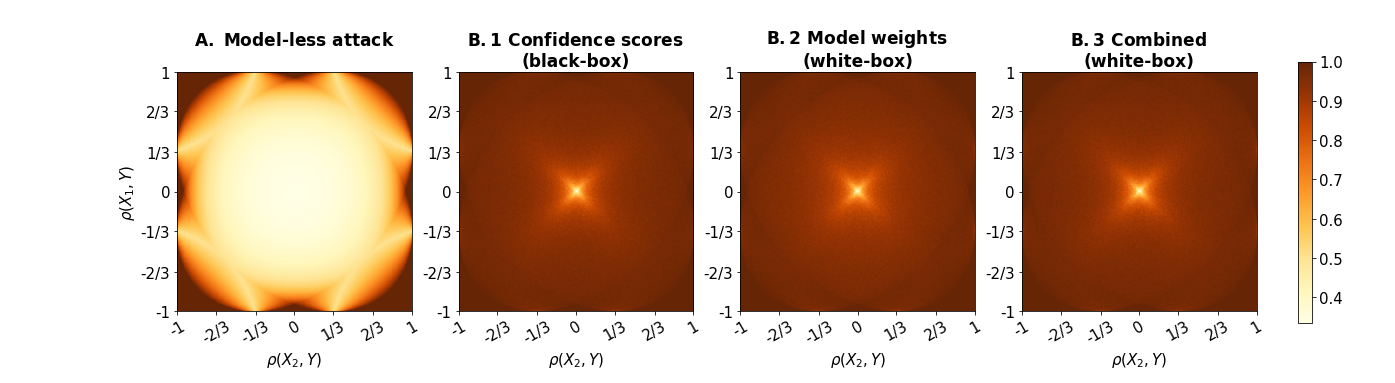

In [13]:
titles = ['$\mathbf{A.}$ Model-less attack\n', '$\mathbf{B. 1}$ Confidence scores \n(black-box)', 
          '$\mathbf{B. 2}$ Model weights \n(white-box)', '$\mathbf{B. 3}$ Combined \n(white-box)']

logreg_accuracies_to_plot = [logreg_accuracy_uniform_prior_empirical,
                      logreg_accuracy_access_to_ml['model_predictions'],
                      logreg_accuracy_access_to_ml['model_weights'],
                      logreg_accuracy_access_to_ml['combined']]
plot_visualisation(logreg_accuracies_to_plot, titles, model_type='logreg')

In [14]:
mlp_accuracy_uniform_prior_empirical = [[
    mlp_grid_attack_results['results'][(a, b)]['uniform_prior_empirical_results']['acc']
    for b in bounds_list[1]] 
    for a in bounds_list[0][::-1]]
fnames = ['model_weights', 'model_weights_canonical', 'model_predictions', 'combined']
mlp_accuracy_access_to_ml = {fname: [[mlp_grid_attack_results['results'][(a, b)][fname][0] 
                         for b in bounds_list[1]] 
                        for a in bounds_list[0][::-1]]
                        for fname in fnames}

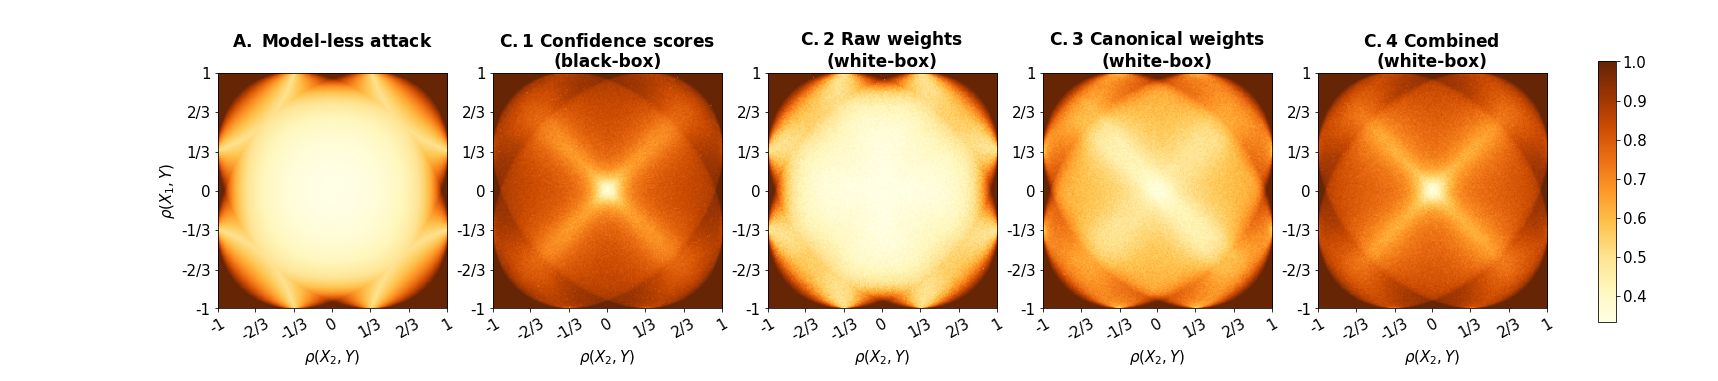

In [15]:
titles = ['$\mathbf{A.}$ Model-less attack\n', 
          '$\mathbf{C. 1}$ Confidence scores \n(black-box)', 
          '$\mathbf{C. 2}$ Raw weights \n(white-box)', 
          '$\mathbf{C. 3}$ Canonical weights \n(white-box)',
          '$\mathbf{C. 4}$ Combined \n(white-box)']
mlp_accuracies_to_plot = [mlp_accuracy_uniform_prior_empirical,
                      mlp_accuracy_access_to_ml['model_predictions'],
                      mlp_accuracy_access_to_ml['model_weights'],
                    mlp_accuracy_access_to_ml['model_weights_canonical'],
                      mlp_accuracy_access_to_ml['combined']]
plot_visualisation(mlp_accuracies_to_plot, titles, model_type='mlptorch')

# 2 - Increasing number of variables - Logistic Regression

We evaluate the correlation inference attack on randomized target matrices for increasing number of variables.

## 2.A - Comparison between the three constraints scenarios

In [16]:
nbrs_columns = np.arange(3, 11, 1)
nbrs_shadow_datasets = [5000]*3 + [10000]* 5
constraints_scenarios = ['column', 'two', 'all_but_target']
titles = [
    r"S2. $(\rho(X_i, Y))_{i=1,\ldots,n-1}$", 
    r"S1. $\rho(X_1, Y)$ and $\rho(X_2, Y)$",
    r"S3. All but $\rho(X_1, X_2)$"]

In [17]:
def get_results_randomized_target_attack(shadow_model_type, meta_model_type, nbrs_columns, experiment_path, 
                                         constraints_scenario='', nbr_bins=3, same_seed="False", verbose=False):
    randomized_target_results_paths = \
        [f'{experiment_path}/cols-{nbr_columns}/{constraints_scenario}/' + \
         f'seed_{same_seed}_nt-1000_ns-{nbrs_shadow_datasets[n]}_nds-1000_ndsbb-100' + \
         f'_smt-{shadow_model_type}_mmt-{meta_model_type}_nb-{nbr_bins}_sgf--1.pickle'
        for n, nbr_columns in enumerate(nbrs_columns)]

    randomized_target_results = dict()

    for n, path in enumerate(randomized_target_results_paths):
        if not os.path.exists(path):
            break
        with open(path, 'rb') as f:
            saved_result = pickle.load(f)
            if not (shadow_model_type == 'mlptorch' and not saved_result['done']):
                if verbose:
                    print(f'Found results for {path}...')
                randomized_target_results[nbrs_columns[n]] = saved_result
    
    print(f'Found {len(randomized_target_results)} results for shadow model type={shadow_model_type}', 
          f'and constraints_scenario={constraints_scenario}\n')
    
    assert 3 in randomized_target_results, 'ERROR: The results for n=3 columns are not available.'
    methods = randomized_target_results[3]['accuracy'].keys()
    accuracy = {method: {n: result['accuracy'][method] for n, result in randomized_target_results.items()}
                for method in methods}
 
    return accuracy

In [18]:
accuracy_constraints = OrderedDict({shadow_model_type: {constraints_scenario:
    get_results_randomized_target_attack(shadow_model_type, 
                                         meta_model_type, 
                                         nbrs_columns, 
                                         experiments_dir + '/randomized_target_attack/balanced_train_test', 
                                         constraints_scenario)
        for constraints_scenario in constraints_scenarios}
                        for shadow_model_type, meta_model_type in [('logreg', 'logreg'), ('mlptorch', 'mlptorch')]
})
print(accuracy_constraints.keys())

Found 8 results for shadow model type=logreg and constraints_scenario=column

Found 8 results for shadow model type=logreg and constraints_scenario=two

Found 8 results for shadow model type=logreg and constraints_scenario=all_but_target

Found 8 results for shadow model type=mlptorch and constraints_scenario=column

Found 8 results for shadow model type=mlptorch and constraints_scenario=two

Found 8 results for shadow model type=mlptorch and constraints_scenario=all_but_target

odict_keys(['logreg', 'mlptorch'])


In [19]:
def plot_results_randomized_target(accuracy, constraints_scenarios, nbrs_columns, titles):
    gs_kw = dict(width_ratios=[1, 0.45], height_ratios=[1, 1])
    fig, axes = plt.subplot_mosaic([['left', 'upper right'],
                                   ['left', 'lower right']],
                                   gridspec_kw=gs_kw,
                                  figsize=(11, 7.2),
                                  constrained_layout=True)
    labels = ["Logistic regression",  "MLP", "Model-less attack"]
    markers = ['o', 'D', '+']
    linestyles = ['-', '--', '-.']
    
    axes_names = ['left', 'upper right', 'lower right']

    model_types = list(accuracy.keys())

    for i, cs in enumerate(constraints_scenarios):
        print('Scenario', cs)
        
        fontsize_ticks = 19 if i == 0 else 15
        
        aname = axes_names[i]

        for mi, model_type in enumerate(model_types):
            print('Model', model_type)
            acc_attack = accuracy[model_type][cs]['model_predictions']
            x = sorted(list(acc_attack.keys()))
            y = np.array([acc_attack[n] for n in x])
            print(','.join([f'n={n}: {acc:.1%}' for n, acc in zip(x,y)]))
            axes[aname].plot(x, y, color='k', label=labels[mi], marker=markers[mi], ls=linestyles[mi])
            std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for n, acc in acc_attack.items()])
            axes[aname].fill_between(x, y-std_error, y+std_error, color='gray', alpha=0.1)
            
        # Model-less attack.
        acc_upe = accuracy['logreg'][cs]['uniform_prior_empirical']
        x = sorted(list(acc_upe.keys()))
        y = np.array([acc_upe[n] for n in x])
        print('Model-less attack', ','.join([f'n={n}: {acc:.1%}' for n, acc in zip(x,y)]))
        axes[aname].plot(x, y, color='k', label=labels[-1], marker=markers[-1], ls=linestyles[-1])
        std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for n, acc in acc_upe.items()])
        axes[aname].fill_between(x, y-std_error, y+std_error, color='gray', alpha=0.1)

        axes[aname].axhline(y=1/3, color='k', ls=':', label='Random baseline')
        axes[aname].set_xlim(nbrs_columns[0], nbrs_columns[-1])
        axes[aname].set_xticks(nbrs_columns)
        axes[aname].set_xticklabels(nbrs_columns, fontsize=fontsize_ticks)
        if i != 1:
            axes[aname].set_xlabel('Number of variables $n$', fontsize=19)
        axes[aname].set_ylim(0, 1)
        if i == 0:
            yticks = np.arange(0, 1.01, 0.1)
        else:
            yticks = np.arange(0, 1.01, 0.2)
        axes[aname].set_yticks(yticks)
        axes[aname].set_yticklabels([f'{t:.1f}' for t in yticks], fontsize=fontsize_ticks)
        axes[aname].set_ylabel('Accuracy', fontsize=19)
        axes[aname].set_title(titles[i], fontweight='bold', fontsize=19)

        if i == 0:
            axes[aname].legend(fontsize=17, loc='lower right', frameon=False)

    plt.savefig(f'../../plots/rand-tar-attack-comparison-constraints.pdf', bbox_inches='tight')
    plt.savefig(f'../../plots/rand-tar-attack-comparison-constraints.png', bbox_inches='tight')
    plt.show()

Scenario column
Model logreg
n=3: 96.1%,n=4: 85.1%,n=5: 77.7%,n=6: 70.4%,n=7: 63.8%,n=8: 65.1%,n=9: 62.6%,n=10: 58.2%
Model mlptorch
n=3: 84.7%,n=4: 79.9%,n=5: 72.3%,n=6: 68.6%,n=7: 63.8%,n=8: 63.1%,n=9: 63.4%,n=10: 57.4%
Model-less attack n=3: 48.6%,n=4: 50.2%,n=5: 50.0%,n=6: 47.5%,n=7: 49.5%,n=8: 48.5%,n=9: 51.6%,n=10: 48.5%
Scenario two
Model logreg
n=3: 95.5%,n=4: 78.5%,n=5: 69.5%,n=6: 63.4%,n=7: 62.3%,n=8: 62.7%,n=9: 60.0%,n=10: 55.5%
Model mlptorch
n=3: 83.1%,n=4: 74.0%,n=5: 68.7%,n=6: 62.1%,n=7: 63.2%,n=8: 61.9%,n=9: 63.5%,n=10: 58.6%
Model-less attack n=3: 48.6%,n=4: 50.2%,n=5: 50.0%,n=6: 47.5%,n=7: 49.5%,n=8: 48.5%,n=9: 51.6%,n=10: 48.5%
Scenario all_but_target
Model logreg
n=3: 95.5%,n=4: 97.7%,n=5: 99.0%,n=6: 99.5%,n=7: 99.6%,n=8: 99.2%,n=9: 99.6%,n=10: 99.9%
Model mlptorch
n=3: 83.1%,n=4: 89.6%,n=5: 93.6%,n=6: 95.6%,n=7: 97.9%,n=8: 97.5%,n=9: 98.7%,n=10: 99.9%
Model-less attack n=3: 48.6%,n=4: 65.4%,n=5: 78.5%,n=6: 88.6%,n=7: 95.6%,n=8: 96.7%,n=9: 98.8%,n=10: 99.9%


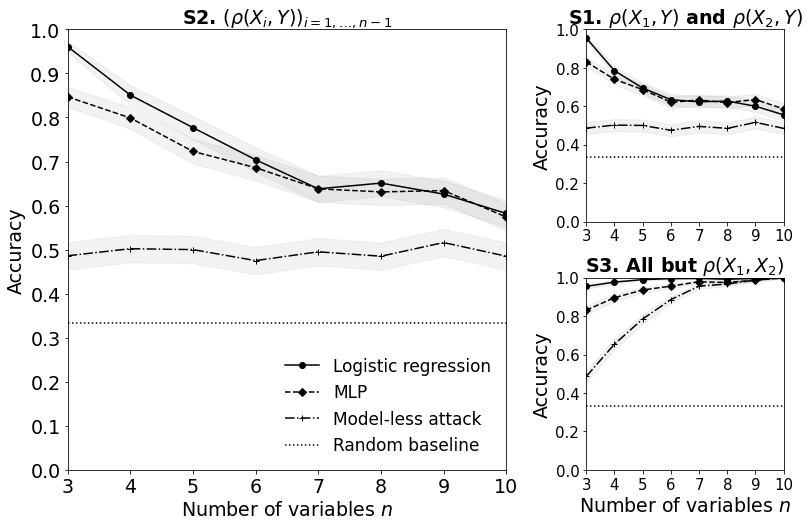

In [20]:
plot_results_randomized_target(accuracy_constraints, constraints_scenarios, nbrs_columns, titles)

Found 8 results for shadow model type=logreg and constraints_scenario=column

Found 8 results for shadow model type=mlptorch and constraints_scenario=column



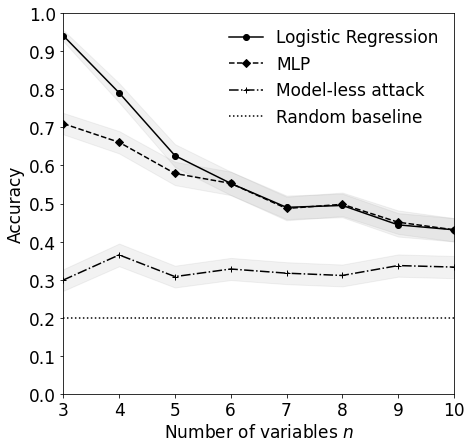

In [21]:
def plot_results_5bins(accuracy):
    fig, ax = plt.subplots(figsize=(7, 7))
    labels = ["Logistic Regression",  "MLP", "Model-less attack"]
    markers = ['o', 'D', '+']
    linestyles = ['-', '--', '-.']
    

    model_types = sorted(list(accuracy.keys()))

    fontsize_ticks = 17
        
    for mi, model_type in enumerate(model_types):
        acc_attack = accuracy[model_type]['model_predictions']
        x = sorted(list(acc_attack.keys()))
        y = np.array([acc_attack[n] for n in x])
        ax.plot(x, y, color='k', label=labels[mi], marker=markers[mi], ls=linestyles[mi])
        std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for n, acc in acc_attack.items()])
        ax.fill_between(x, y-std_error, y+std_error, color='gray', alpha=0.1)

    # Model-less attack.
    acc_upe = accuracy['logreg']['uniform_prior_empirical']
    x = sorted(list(acc_upe.keys()))
    y = np.array([acc_upe[n] for n in x])
    ax.plot(x, y, color='k', label=labels[-1], marker=markers[-1], ls=linestyles[-1])
    std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for n, acc in acc_upe.items()])
    ax.fill_between(x, y-std_error, y+std_error, color='gray', alpha=0.1)

    ax.axhline(y=1/5, color='k', ls=':', label='Random baseline')
    ax.set_xlim(nbrs_columns[0], nbrs_columns[-1])
    ax.set_xticks(nbrs_columns)
    ax.set_xticklabels(nbrs_columns, fontsize=fontsize_ticks)
    ax.set_xlabel('Number of variables $n$', fontsize=17)
    ax.set_ylim(0, 1)
    yticks = np.arange(0, 1.01, 0.1)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{t:.1f}' for t in yticks], fontsize=fontsize_ticks)
    ax.set_ylabel('Accuracy', fontsize=17)

    ax.legend(fontsize=17, loc='upper right', frameon=False)

    plt.savefig(f'../../plots/rand-tar-attack-5-bins.pdf', bbox_inches='tight')
    plt.savefig(f'../../plots/rand-tar-attack-5-bins.png', bbox_inches='tight')
    plt.show()
    
accuracy_5bins = {model_type: get_results_randomized_target_attack(model_type,
                                         model_type, 
                                         nbrs_columns, 
                                         experiments_dir + '/randomized_target_attack/balanced_train_test', 
                                         constraints_scenario='column',
                                         nbr_bins=5)
                        for model_type in ['logreg', 'mlptorch']}
plot_results_5bins(accuracy_5bins)

# Impact of largest constraint

Replace np.max with np.mean and np.min two cells below, then update the figure's title accordingly, to plot the results for the impact of the average and smallest constraint, respectively.

In [22]:
def get_predictions(shadow_model_type, meta_model_type, nbrs_columns, experiment_path, 
                                         constraints_scenario='', verbose=False):
    randomized_target_results_paths = \
        [f'{experiment_path}/cols-{nbr_columns}/{constraints_scenario}/' + \
         f'seed_False_nt-1000_ns-{nbrs_shadow_datasets[n]}_nds-1000_ndsbb-100' + \
         f'_smt-{shadow_model_type}_mmt-{meta_model_type}_nb-3_sgf--1.pickle'
        for n, nbr_columns in enumerate(nbrs_columns)]

    randomized_target_results = dict()

    for n, path in enumerate(randomized_target_results_paths):
        if not os.path.exists(path):
            break
        with open(path, 'rb') as f:
            saved_result = pickle.load(f)
            if (shadow_model_type == 'mlptorch' and saved_result['done']) or shadow_model_type == 'logreg':
                if verbose:
                    print(f'Found results for {path}...')
                randomized_target_results[nbrs_columns[n]] = saved_result
    
    print(f'Found {len(randomized_target_results)} results for shadow model type={shadow_model_type}', 
          f'and constraints_scenario={constraints_scenario}\n')
    
    methods = randomized_target_results[3]['accuracy'].keys()

    predictions = dict()
    for method in methods:
        predictions[method] = dict()
        for n, result in randomized_target_results.items():
            predictions[method][n] = dict()
            for i, bounds in enumerate(result['bounds']):
                if constraints_scenario == 'all_but_target':
                    pair_constraints = bounds[0][:2]
                else:
                    pair_constraints = bounds[:2]
                predictions[method][n][tuple(pair_constraints)] = (result['pred_labels'][method][i] == result['target_labels'][i])  
    return predictions

Found 8 results for shadow model type=logreg and constraints_scenario=column

[0.6271186440677966, 0.6174496644295302, 0.672316384180791, 0.7403314917127072, 0.9054054054054054]
[0.2542372881355932, 0.3422818791946309, 0.3728813559322034, 0.5469613259668509, 0.8108108108108109]


<ipython-input-23-b3a6ccb90896>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1.0)'], rotation=30)


Found 8 results for shadow model type=mlptorch and constraints_scenario=column

[0.5932203389830508, 0.5704697986577181, 0.6892655367231638, 0.7237569060773481, 0.8243243243243243]
[0.2542372881355932, 0.3422818791946309, 0.3728813559322034, 0.5469613259668509, 0.8108108108108109]


<ipython-input-23-b3a6ccb90896>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1.0)'], rotation=30)


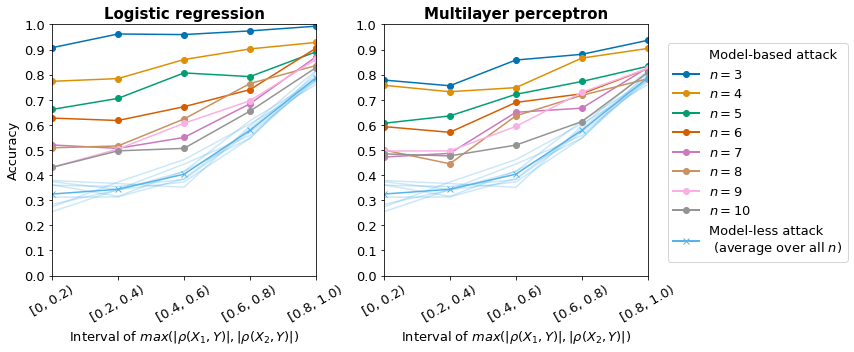

In [23]:
from collections import defaultdict

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = np.array([c for c in sns.color_palette("colorblind", 10)])
methods = ['model_predictions', 'uniform_prior_empirical']
model_types = ['logreg', 'mlptorch']
titles = ['Logistic regression', 'Multilayer perceptron']
x = np.arange(5)

for ai, ax in enumerate(axes):
    model_type = model_types[ai]
    predictions = get_predictions(model_type, 
                              model_type,  
                              nbrs_columns, 
                              experiments_dir + '/randomized_target_attack/balanced_train_test', 
                              constraints_scenario='column')

    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]


    accs = {n : dict() for n in nbrs_columns}

    for n in nbrs_columns:
        #print(f'n={n} variables\n')
        for method in methods:
            #print(f'Method {method}')
            int_to_corr_count = defaultdict(int)
            int_to_count = defaultdict(int)
            for bi in range(len(bins)-1):
                b_start, b_end = bins[bi], bins[bi+1]
                for pair, pred in predictions[method][n].items():
                    #Replace np.max with np.mean and np.min two cells below, then update the figure's title accordingly, 
                    # to plot the results for the impact of the average and smallest constraint, respectively.
                    if b_start <= np.max(pair) < b_end:
                        int_to_count[ (b_start, b_end) ] += 1
                        int_to_corr_count[ (b_start, b_end) ] += int(pred)
            acc = [ int_to_corr_count[p] / int_to_count[p] for p in int_to_count]
            accs[n][method] = acc


    print(accs[6]['model_predictions'])
    print(accs[6]['uniform_prior_empirical'])
    for ni, n in enumerate(nbrs_columns):
        ax.plot(x, accs[n]['model_predictions'], color=colors[ni],  label=f'n={n}', marker='o')
        ax.plot(x, accs[n]['uniform_prior_empirical'], color=colors[9], alpha=0.3)
    ax.plot(x, np.mean([accs[n]['uniform_prior_empirical'] for n in nbrs_columns], axis=0), color=colors[9], marker='x')
    ax.set_xlabel('Interval of $max(|\\rho(X_1, Y)|,|\\rho(X_2, Y)|)$', fontsize=13)
    ax.set_xlim(0, 4)
    ax.set_xticklabels(['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1.0)'], rotation=30)
    ax.set_ylim(0, 1)
    if ai == 0:
        ax.set_ylabel('Accuracy', fontsize=13)
    ax.set_yticks(np.linspace(0, 1, 11))
    ax.tick_params(axis='both', labelsize=13)
    ax.set_title(titles[ai], fontsize=15, fontweight='bold')

custom_lines = [Line2D([], [], color=cmap(0.), lw=0),
                    Line2D([0], [0], color=colors[0], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[1], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[2], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[3], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[4], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[5], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[6], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[7], lw=2, marker='o'),
                    Line2D([0], [0], color=colors[9], lw=2, marker='x')]
custom_names = ['Model-based attack',
                '$n = 3$','$n = 4$','$n = 5$','$n = 6$','$n = 7$','$n = 8$','$n = 9$','$n = 10$',
                'Model-less attack \n (average over all $n$)']
 
if ai == 1:
    ax.legend(custom_lines, custom_names, fontsize=13, bbox_to_anchor=(1.05, 0.95))

plt.tight_layout()
plt.savefig('../../plots/impact-of-largest-constraint.pdf')
plt.savefig('../../plots/impact-of-largest-constraint.png')
plt.show()

# MLP - same seed

In [24]:
accuracy_seed = {same_seed:
    get_results_randomized_target_attack('mlptorch', 
                                         'mlptorch', 
                                         nbrs_columns, 
                                         experiments_dir + '/randomized_target_attack/balanced_train_test', 
                                         'column', 
                                         same_seed=same_seed
                                        )
        for same_seed in ["False", "True"]
}
print(accuracy_seed.keys(), accuracy_seed["True"].keys())

Found 8 results for shadow model type=mlptorch and constraints_scenario=column

Found 8 results for shadow model type=mlptorch and constraints_scenario=column

dict_keys(['False', 'True']) dict_keys(['largest_bin', 'uniform_prior_empirical', 'model_weights', 'model_weights_canonical', 'model_predictions', 'combined'])



Method=model_predictions
Same seed=False
n=3, acc=84.7%,n=4, acc=79.9%,n=5, acc=72.3%,n=6, acc=68.6%,n=7, acc=63.8%,n=8, acc=63.1%,n=9, acc=63.4%,n=10, acc=57.4%
Same seed=True
n=3, acc=89.1%,n=4, acc=82.1%,n=5, acc=76.9%,n=6, acc=71.3%,n=7, acc=66.9%,n=8, acc=66.6%,n=9, acc=61.3%,n=10, acc=58.4%
n=3, gap=4.4%,n=4, gap=2.2%,n=5, gap=4.6%,n=6, gap=2.7%,n=7, gap=3.1%,n=8, gap=3.5%,n=9, gap=-2.1%,n=10, gap=1.0%

Method=model_weights
Same seed=False
n=3, acc=52.3%,n=4, acc=51.1%,n=5, acc=52.8%,n=6, acc=51.3%,n=7, acc=51.3%,n=8, acc=53.1%,n=9, acc=53.3%,n=10, acc=50.8%
Same seed=True
n=3, acc=94.5%,n=4, acc=93.0%,n=5, acc=89.9%,n=6, acc=88.4%,n=7, acc=86.6%,n=8, acc=83.0%,n=9, acc=83.0%,n=10, acc=78.3%
n=3, gap=42.2%,n=4, gap=41.9%,n=5, gap=37.1%,n=6, gap=37.1%,n=7, gap=35.3%,n=8, gap=29.9%,n=9, gap=29.7%,n=10, gap=27.5%

Method=model_weights_canonical
Same seed=False
n=3, acc=71.6%,n=4, acc=61.1%,n=5, acc=61.3%,n=6, acc=56.2%,n=7, acc=56.1%,n=8, acc=55.2%,n=9, acc=57.0%,n=10, acc=53.6%
Sa

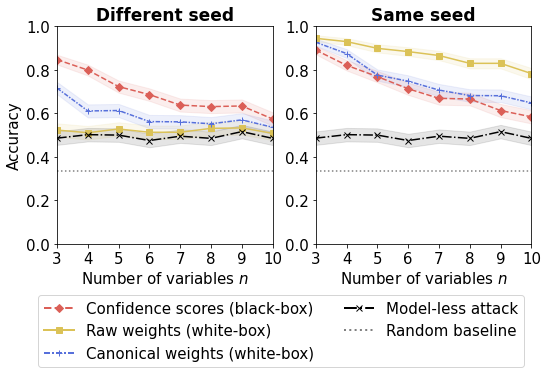

In [25]:
methods = np.array(['model_predictions', 'model_weights', 'model_weights_canonical'])
colors = np.array([c for c in sns.color_palette("hls", 8)])[[0, 1, 5]]
linestyles = ['--', '-',  (0, (3, 1, 1, 1))]
markers = ['D', 's', '+', 'd']
titles = ["Different seed", "Same seed"]

fig, axes = plt.subplots(1, 2, figsize=(8.5, 4))
for j, method in enumerate(methods):
    print(f'\nMethod={method}')
    for ai, same_seed in enumerate(["False", "True"]):
        print(f'Same seed={same_seed}')
        x = sorted(list(accuracy_seed[same_seed][method].keys()))
        y = [accuracy_seed[same_seed][method][n] for n in x]
        print(','.join([f'n={n}, acc={acc:.1%}' for n, acc in zip(x, y)]))
        if ai == 0:
            gap = -np.array(y)
        else:
            gap = gap + np.array(y)
            print(','.join([f'n={n}, gap={g:.1%}' for n, g in zip(x, gap)]))
        axes[ai].plot(x, y, color=colors[j], ls=linestyles[j], marker=markers[j])
        
        std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for acc in y])
        axes[ai].fill_between(x, y-std_error, y+std_error, color=colors[j], alpha=0.1)

print(f'\nMethod=uniform_prior_empirical')
for ai, same_seed in enumerate(["False", "True"]):
    x = sorted(list(accuracy_seed['False']['uniform_prior_empirical'].keys()))
    y = [accuracy_seed['False']['uniform_prior_empirical'][n] for n in x]
    print(','.join([f'n={n}, acc={acc:.1%}' for n, acc in zip(x, y)]))
    axes[ai].plot(x, y, color='k', ls='-.', marker='x')
    std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for acc in y])
    axes[ai].fill_between(x, y-std_error, y+std_error, color='k', alpha=0.1)

    axes[ai].axhline(y=1/3, color='gray', ls=':', label='Random baseline')
    axes[ai].set_xlim(nbrs_columns[0], nbrs_columns[-1])
    axes[ai].set_xticks(nbrs_columns)
    axes[ai].set_xticklabels(nbrs_columns, fontsize=15)
    axes[ai].set_xlabel('Number of variables $n$', fontsize=15)
    axes[ai].set_ylim(0, 1)
    yticks = np.arange(0, 1.01, 0.2)
    axes[ai].set_yticks(yticks)
    axes[ai].set_yticklabels([f'{t:.1f}' for t in yticks], fontsize=15)
    axes[ai].set_title(titles[ai], fontweight='bold', fontsize=17)
        
axes[0].set_ylabel('Accuracy', fontsize=15)

custom_lines = [Line2D([0], [0], color=colors[0], lw=2, ls=linestyles[0], marker=markers[0]),
                Line2D([0], [0], color=colors[1], lw=2, ls=linestyles[1], marker=markers[1]),
                Line2D([0], [0], color=colors[2], lw=2, ls=linestyles[2], marker=markers[2]), 
                Line2D([0], [0], color='k', lw=2, ls='-.', marker='x'), 
                Line2D([0], [0], color='gray', lw=2, ls=':')]

custom_names = np.array(['Confidence scores (black-box)', 'Raw weights (white-box)', 
                   'Canonical weights (white-box)', 'Model-less attack', 'Random baseline'])

axes[0].legend(custom_lines, custom_names, fontsize=15, bbox_to_anchor=(2.2, -0.2), ncol=2)

#plt.tight_layout()
plt.savefig('../../plots/impact-of-seed-mlp.pdf', bbox_inches='tight')
plt.savefig('../../plots/impact-of-seed-mlp.png', bbox_inches='tight')
plt.show()

# Mitigations

In [26]:
def get_results_mitigations(shadow_model_type, meta_model_type, nbrs_columns, mitigations_path, 
                            nbrs_sgf, nbrs_data_samples_bb_aux, verbose=False):
    mitigations_results_paths = \
        [f'{mitigations_path}/cols-{nbr_columns}/column/' + \
         f'nt-1000_ns-5000_nds-1000_ndsbb-{nbrs_data_samples_bb_aux}' + \
         f'_smt-{shadow_model_type}_mmt-{meta_model_type}_nb-3_sgf-{nbrs_sgf}.pickle'
        for n, nbr_columns in enumerate(nbrs_columns)]

    mitigations_results = dict()

    for n, path in enumerate(mitigations_results_paths):
        if not os.path.exists(path):
            break
        with open(path, 'rb') as f:
            saved_result = pickle.load(f)
            if (shadow_model_type == 'mlptorch' and saved_result['done']) or shadow_model_type == 'logreg':
                if verbose:
                    print(f'Found results for {path}...')
                mitigations_results[nbrs_columns[n]] = saved_result
    
    print(f'Found {len(mitigations_results)} results for shadow model type={shadow_model_type}', 
          f'nbrs_signficant_figures={nbrs_sgf} and ndsbb={nbrs_data_samples_bb_aux}\n')
    
    assert 3 in mitigations_results, 'ERROR: The results for n=3 columns are not available.'
    mitigations = mitigations_results[3]['accuracy'].keys()
    accuracy = {n: result['accuracy'] for n, result in mitigations_results.items()}
    return accuracy

Found 3 results for shadow model type=logreg nbrs_signficant_figures=0,1,2,3,-1 and ndsbb=1,2,5,10,20,50,100,200,500,1000,2000,5000

{3: {'nbr_significant_figures': {0: 0.908, 1: 0.957, 2: 0.954, 3: 0.96, -1: 0.96}, 'nbr_queries': {1: 0.791, 2: 0.912, 5: 0.958, 10: 0.96, 20: 0.958, 50: 0.959, 100: 0.96, 200: 0.958, 500: 0.959, 1000: 0.958, 2000: 0.956, 5000: 0.958}}, 4: {'nbr_significant_figures': {0: 0.772, 1: 0.83, 2: 0.849, 3: 0.849, -1: 0.849}, 'nbr_queries': {1: 0.622, 2: 0.658, 5: 0.746, 10: 0.779, 20: 0.807, 50: 0.838, 100: 0.849, 200: 0.849, 500: 0.865, 1000: 0.873, 2000: 0.87, 5000: 0.869}}, 5: {'nbr_significant_figures': {0: 0.719, 1: 0.763, 2: 0.783, 3: 0.779, -1: 0.784}, 'nbr_queries': {1: 0.59, 2: 0.594, 5: 0.676, 10: 0.709, 20: 0.757, 50: 0.751, 100: 0.784, 200: 0.776, 500: 0.78, 1000: 0.774, 2000: 0.777, 5000: 0.78}}}
Found 3 results for shadow model type=logreg and constraints_scenario=column

0.496


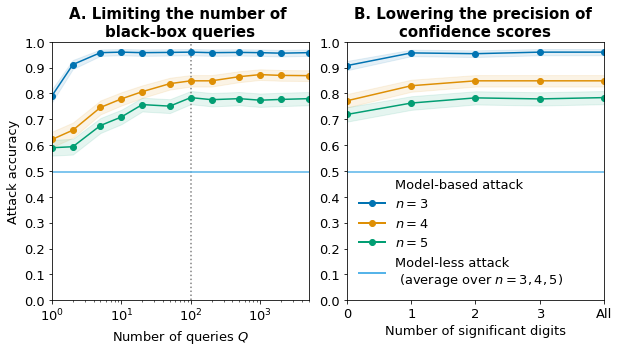

Found 3 results for shadow model type=mlptorch nbrs_signficant_figures=0,1,2,3,-1 and ndsbb=1,2,5,10,20,50,100,200,500,1000,2000,5000

{3: {'nbr_significant_figures': {0: 0.807, 1: 0.837, 2: 0.833, 3: 0.832, -1: 0.828}, 'nbr_queries': {1: 0.687, 2: 0.726, 5: 0.798, 10: 0.815, 20: 0.829, 50: 0.833, 100: 0.828, 200: 0.839, 500: 0.83, 1000: 0.831, 2000: 0.819, 5000: 0.818}}, 4: {'nbr_significant_figures': {0: 0.735, 1: 0.778, 2: 0.786, 3: 0.785, -1: 0.786}, 'nbr_queries': {1: 0.596, 2: 0.635, 5: 0.719, 10: 0.738, 20: 0.753, 50: 0.771, 100: 0.786, 200: 0.801, 500: 0.798, 1000: 0.785, 2000: 0.786, 5000: 0.788}}, 5: {'nbr_significant_figures': {0: 0.672, 1: 0.73, 2: 0.742, 3: 0.742, -1: 0.747}, 'nbr_queries': {1: 0.591, 2: 0.608, 5: 0.661, 10: 0.686, 20: 0.713, 50: 0.721, 100: 0.747, 200: 0.741, 500: 0.739, 1000: 0.753, 2000: 0.764, 5000: 0.736}}}
Found 3 results for shadow model type=mlptorch and constraints_scenario=column

0.496


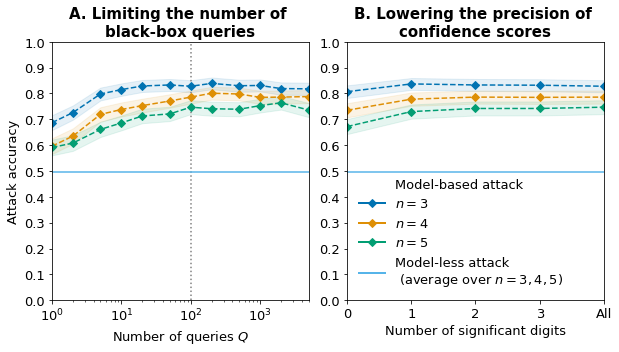

In [27]:
markers = ['o', 'D']
linestyles = ['-', '--']
for mi, model_type in enumerate(['logreg', 'mlptorch']):
    mitigations_path = os.path.join(experiments_dir, 'randomized_target_attack_mitigations')
    nbrs_columns_mitigations = [3, 4, 5]
    acc_mitigations = get_results_mitigations(model_type, model_type, nbrs_columns_mitigations, mitigations_path, 
                           nbrs_sgf='0,1,2,3,-1', nbrs_data_samples_bb_aux='1,2,5,10,20,50,100,200,500,1000,2000,5000')
    print(acc_mitigations)
    
    acc_baseline = get_results_randomized_target_attack(model_type, model_type, nbrs_columns_mitigations, 
                                                        experiments_dir + '/randomized_target_attack/balanced_train_test', 'column')
    avg_baseline = np.mean([acc_baseline['uniform_prior_empirical'][n] for n in nbrs_columns_mitigations])
    print(avg_baseline)

    fig, axes = plt.subplots(1, 2, figsize=(8.7, 5))
    colors =sns.color_palette("colorblind", 10)

    x_nbrs_sgf = [i for i in acc_mitigations[3]['nbr_significant_figures'] if i >= 0]
    labels_nbrs_sgf = [str(i) for i in x_nbrs_sgf]
    x_nbrs_sgf.append(max(x_nbrs_sgf)+1) # All the figures are kept.
    labels_nbrs_sgf.append('All')

    axes[0].axvline(x=100, color='gray', ls=':')
    nbrs_queries = sorted(list(acc_mitigations[3]['nbr_queries'].keys()))
    for ni, n in enumerate(nbrs_columns_mitigations):
        if n not in acc_mitigations:
            continue
        y = [acc_mitigations[n]['nbr_queries'][nbr_queries] for nbr_queries in nbrs_queries]
        axes[0].plot(nbrs_queries, y,  marker=markers[mi], ls=linestyles[mi],  color=colors[ni])
        std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for acc in y])
        axes[0].fill_between(nbrs_queries, y-std_error, y+std_error, color=colors[ni], alpha=0.1)
    axes[0].axhline(y=avg_baseline, color=colors[9])
    axes[0].set_xscale('log')
    axes[0].set_xlim(1, 5000)
    axes[0].set_xlabel('Number of queries $Q$', fontsize=13)
    axes[0].set_ylabel('Attack accuracy', fontsize=13)
    axes[0].set_title('A. Limiting the number of \nblack-box queries', fontsize=15, fontweight='bold')
    
    for ni, n in enumerate(nbrs_columns_mitigations):
        if n not in acc_mitigations:
            continue
        y = list(acc_mitigations[n]['nbr_significant_figures'].values())
        axes[1].plot(x_nbrs_sgf, y, marker=markers[mi], ls=linestyles[mi], label=r'$n=$'+f'{n}', color=colors[ni])
        std_error = np.array([1.96 * np.sqrt(1/1000 * acc * (1- acc)) for acc in y])
        axes[1].fill_between(x_nbrs_sgf, y-std_error, y+std_error, color=colors[ni], alpha=0.1)
    axes[1].axhline(y=avg_baseline, color=colors[9])
    axes[1].set_xlim(x_nbrs_sgf[0], x_nbrs_sgf[-1])
    axes[1].set_xticks(x_nbrs_sgf)
    axes[1].set_xticklabels(labels_nbrs_sgf)
    axes[1].set_xlabel('Number of significant digits', fontsize=13)

    axes[1].set_title('B. Lowering the precision of \nconfidence scores', fontsize=15, fontweight='bold')

    for ax in axes:
        ax.tick_params(axis='both', labelsize=13)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.linspace(0, 1, 11))

    #axes[1].legend(fontsize=13)
    
    custom_lines = [Line2D([], [], color=cmap(0.), lw=0),
                    Line2D([0], [0], color=colors[0], lw=2, marker=markers[mi]),
                    Line2D([0], [0], color=colors[1], lw=2, marker=markers[mi]),
                    Line2D([0], [0], color=colors[2], lw=2, marker=markers[mi]),
                    Line2D([0], [0], color=colors[9], lw=2)]
    custom_names = ['Model-based attack',
                '$n = 3$','$n = 4$','$n = 5$',
                'Model-less attack \n (average over $n=3,4,5$)']
    
    axes[1].legend(custom_lines, custom_names, fontsize=13, frameon=False)

    plt.tight_layout()
    plt.savefig(f'../../plots/mitigations-{model_type}.pdf', bbox_inches='tight')
    plt.savefig(f'../../plots/mitigations-{model_type}.png', bbox_inches='tight')
    plt.show()